# Sakila Database Analysis

**Author:** Henrik Göransson  
**Purpose:** Data analysis on Sakila DVD rental database  
**Database:** DuckDB migration from SQLite Sakila database


## Setup and Database Connection

In [16]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Connect to DuckDB database using context manager (best practice)
db_path = Path("../data/sakila.duckdb")

# Note: We keep connection open for the entire notebook
# In production, use: with duckdb.connect(str(db_path)) as conn:
conn = duckdb.connect(str(db_path))

print("✓ Connected to Sakila DuckDB database")

✓ Connected to Sakila DuckDB database


## Explore Database Schema

In [17]:
# List all tables
tables_df = conn.sql("SHOW TABLES;").df()
print(f"Total tables: {len(tables_df)}\n")
tables_df

Total tables: 16



,name
0,actor
1,address
2,category
3,city
4,country
5,customer
6,film
7,film_actor
8,film_category
9,film_text


---

## Task 1 - Exploratory Data Analysis

### Question a) Movies longer than 3 hours (180 minutes)

Which movies are longer than 3 hours? Shows the title and its length.

In [18]:
query_a = """
SELECT 
    title,
    length
FROM film
WHERE length > 180
ORDER BY length DESC;
"""

movies_long = conn.sql(query_a).df()
print(f"Found {len(movies_long)} movies longer than 180 minutes\n")
movies_long

Found 39 movies longer than 180 minutes



,title,length
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185
5,GANGS PRIDE,185
6,HOME PITY,185
7,SOLDIERS EVOLUTION,185
8,POND SEATTLE,185
9,MUSCLE BRIGHT,185


### Question b) Movies with "love" in the title

Which movies have the word "love" in its title? Shows title, rating, length, and description.

In [19]:
query_b = """
SELECT 
    title,
    rating,
    length,
    description
FROM film
WHERE LOWER(title) LIKE '%love%'
ORDER BY title;
"""

movies_love = conn.sql(query_b).df()
print(f"Found {len(movies_love)} movies with 'love' in the title\n")
movies_love

Found 10 movies with 'love' in the title



,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
6,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
7,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
8,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
9,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


### Question c) Descriptive statistics on movie length

Calculates shortest, average, median, and longest movie length.

In [20]:
query_c = """
SELECT 
    MIN(length) AS shortest_length,
    AVG(length) AS average_length,
    MEDIAN(length) AS median_length,
    MAX(length) AS longest_length
FROM film;
"""

stats_length = conn.sql(query_c).df()
print("Movie Length Statistics (in minutes):\n")
stats_length

Movie Length Statistics (in minutes):



,shortest_length,average_length,median_length,longest_length
0,46,115.272,114.0,185


### Question d) Top 10 most expensive movies to rent per day

The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie. Calculates the cost per day and show the top 10 most expensive.

In [21]:
query_d = """
SELECT 
    title,
    rental_rate,
    rental_duration,
    ROUND(rental_rate / rental_duration, 2) AS cost_per_day
FROM film
ORDER BY cost_per_day DESC
LIMIT 10;
"""

expensive_movies = conn.sql(query_d).df()
print("Top 10 most expensive movies to rent per day:\n")
expensive_movies

Top 10 most expensive movies to rent per day:



,title,rental_rate,rental_duration,cost_per_day
0,ACE GOLDFINGER,4.99,3,1.66
1,AMERICAN CIRCUS,4.99,3,1.66
2,AUTUMN CROW,4.99,3,1.66
3,BACKLASH UNDEFEATED,4.99,3,1.66
4,BEAST HUNCHBACK,4.99,3,1.66
5,BEHAVIOR RUNAWAY,4.99,3,1.66
6,BILKO ANONYMOUS,4.99,3,1.66
7,CARIBBEAN LIBERTY,4.99,3,1.66
8,CASPER DRAGONFLY,4.99,3,1.66
9,CASUALTIES ENCINO,4.99,3,1.66


### Question e) Top 10 actors by number of movies

Which actors have played in the most movies? Shows the top 10 actors with the number of movies they have played in.

In [22]:
query_e = """
SELECT 
    a.actor_id,
    a.first_name,
    a.last_name,
    COUNT(fa.film_id) AS number_of_movies
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY number_of_movies DESC
LIMIT 10;
"""

top_actors = conn.sql(query_e).df()
print("Top 10 actors by number of movies:\n")
top_actors

Top 10 actors by number of movies:



,actor_id,first_name,last_name,number_of_movies
0,107.0,GINA,DEGENERES,42
1,102.0,WALTER,TORN,41
2,198.0,MARY,KEITEL,40
3,181.0,MATTHEW,CARREY,39
4,23.0,SANDRA,KILMER,37
5,81.0,SCARLETT,DAMON,36
6,37.0,VAL,BOLGER,35
7,158.0,VIVIEN,BASINGER,35
8,144.0,ANGELA,WITHERSPOON,35
9,106.0,GROUCHO,DUNST,35


### Question f) Custom Analysis Questions

Here are 5 additional questions I want to explore:

1. **What is the distribution of movie ratings (G, PG, PG-13, R, NC-17)?**
2. **Which film categories are most popular (have the most films)?**
3. **What are the average rental rates by film category?**
4. **Which customers have rented the most movies?**
5. **What is the average time between a rental and its return?**

#### F1: Distribution of movie ratings

In [23]:
query_f1 = """
SELECT 
    rating,
    COUNT(*) AS number_of_films,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM film
GROUP BY rating
ORDER BY number_of_films DESC;
"""

rating_distribution = conn.sql(query_f1).df()
print("Distribution of movie ratings:\n")
rating_distribution

Distribution of movie ratings:



,rating,number_of_films,percentage
0,PG-13,223,22.3
1,NC-17,210,21.0
2,R,195,19.5
3,PG,194,19.4
4,G,178,17.8


#### F2: Most popular film categories

In [24]:
query_f2 = """
SELECT 
    c.name AS category,
    COUNT(fc.film_id) AS number_of_films
FROM category c
JOIN film_category fc ON c.category_id = fc.category_id
GROUP BY c.name
ORDER BY number_of_films DESC;
"""

popular_categories = conn.sql(query_f2).df()
print("Film categories by number of films:\n")
popular_categories

Film categories by number of films:



,category,number_of_films
0,Sports,74
1,Foreign,73
2,Family,69
3,Documentary,68
4,Animation,66
5,Action,64
6,New,63
7,Drama,62
8,Sci-Fi,61
9,Games,61


#### F3: Average rental rates by category

In [25]:
query_f3 = """
SELECT 
    c.name AS category,
    ROUND(AVG(f.rental_rate), 2) AS avg_rental_rate,
    ROUND(MIN(f.rental_rate), 2) AS min_rental_rate,
    ROUND(MAX(f.rental_rate), 2) AS max_rental_rate
FROM category c
JOIN film_category fc ON c.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
GROUP BY c.name
ORDER BY avg_rental_rate DESC;
"""

rental_by_category = conn.sql(query_f3).df()
print("Average rental rates by category:\n")
rental_by_category

Average rental rates by category:



,category,avg_rental_rate,min_rental_rate,max_rental_rate
0,Games,3.25,0.99,4.99
1,Travel,3.24,0.99,4.99
2,Sci-Fi,3.22,0.99,4.99
3,Comedy,3.16,0.99,4.99
4,Sports,3.13,0.99,4.99
5,New,3.12,0.99,4.99
6,Foreign,3.10,0.99,4.99
7,Horror,3.03,0.99,4.99
8,Drama,3.02,0.99,4.99
9,Music,2.95,0.99,4.99


#### F4: Top customers by number of rentals

In [26]:
query_f4 = """
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    c.email,
    COUNT(r.rental_id) AS total_rentals
FROM customer c
JOIN rental r ON c.customer_id = r.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name, c.email
ORDER BY total_rentals DESC
LIMIT 10;
"""

top_customers_rentals = conn.sql(query_f4).df()
print("Top 10 customers by number of rentals:\n")
top_customers_rentals

Top 10 customers by number of rentals:



,customer_id,first_name,last_name,email,total_rentals
0,148,ELEANOR,HUNT,ELEANOR.HUNT@sakilacustomer.org,46
1,526,KARL,SEAL,KARL.SEAL@sakilacustomer.org,45
2,144,CLARA,SHAW,CLARA.SHAW@sakilacustomer.org,42
3,236,MARCIA,DEAN,MARCIA.DEAN@sakilacustomer.org,42
4,75,TAMMY,SANDERS,TAMMY.SANDERS@sakilacustomer.org,41
5,197,SUE,PETERS,SUE.PETERS@sakilacustomer.org,40
6,469,WESLEY,BULL,WESLEY.BULL@sakilacustomer.org,40
7,137,RHONDA,KENNEDY,RHONDA.KENNEDY@sakilacustomer.org,39
8,178,MARION,SNYDER,MARION.SNYDER@sakilacustomer.org,39
9,468,TIM,CARY,TIM.CARY@sakilacustomer.org,39


#### F5: Average rental duration (actual time between rental and return)

In [27]:
query_f5 = """
SELECT 
    ROUND(AVG(EXTRACT(EPOCH FROM (return_date - rental_date)) / 86400), 2) AS avg_rental_days,
    ROUND(MIN(EXTRACT(EPOCH FROM (return_date - rental_date)) / 86400), 2) AS min_rental_days,
    ROUND(MAX(EXTRACT(EPOCH FROM (return_date - rental_date)) / 86400), 2) AS max_rental_days
FROM rental
WHERE return_date IS NOT NULL;
"""

rental_duration_stats = conn.sql(query_f5).df()
print("Rental duration statistics (in days):\n")
rental_duration_stats

Rental duration statistics (in days):



,avg_rental_days,min_rental_days,max_rental_days
0,5.03,0.75,9.25


---

## Task 2 - Visualizations

### Graph a) Top 5 customers by total spend

The Manager wants to reward the top customers with special offers. This visualize who our best customers are by total spend.

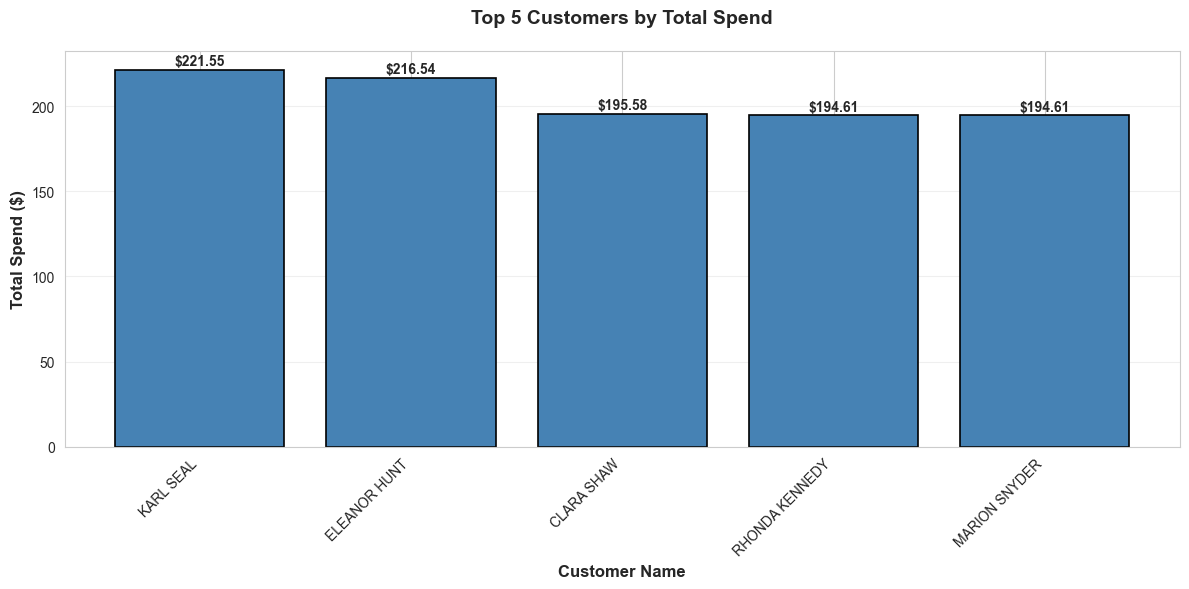


Top 5 Customers:



,customer_id,customer_name,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,137,RHONDA KENNEDY,194.61
4,178,MARION SNYDER,194.61


In [28]:
query_2a = """
SELECT 
    c.customer_id,
    c.first_name || ' ' || c.last_name AS customer_name,
    SUM(p.amount) AS total_spend
FROM customer c
JOIN payment p ON c.customer_id = p.customer_id
GROUP BY c.customer_id, customer_name
ORDER BY total_spend DESC
LIMIT 5;
"""

top_5_customers = conn.sql(query_2a).df()

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_5_customers['customer_name'], top_5_customers['total_spend'], 
        color='steelblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Customer Name', fontsize=12, fontweight='bold')
plt.ylabel('Total Spend ($)', fontsize=12, fontweight='bold')
plt.title('Top 5 Customers by Total Spend', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (name, value) in enumerate(zip(top_5_customers['customer_name'], top_5_customers['total_spend'])):
    plt.text(i, value + 1, f'${value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTop 5 Customers:\n")
top_5_customers

### Graph b) Total revenue per film category

Understanding which categories bring in the most revenue helps The Manager make better inventory decisions.

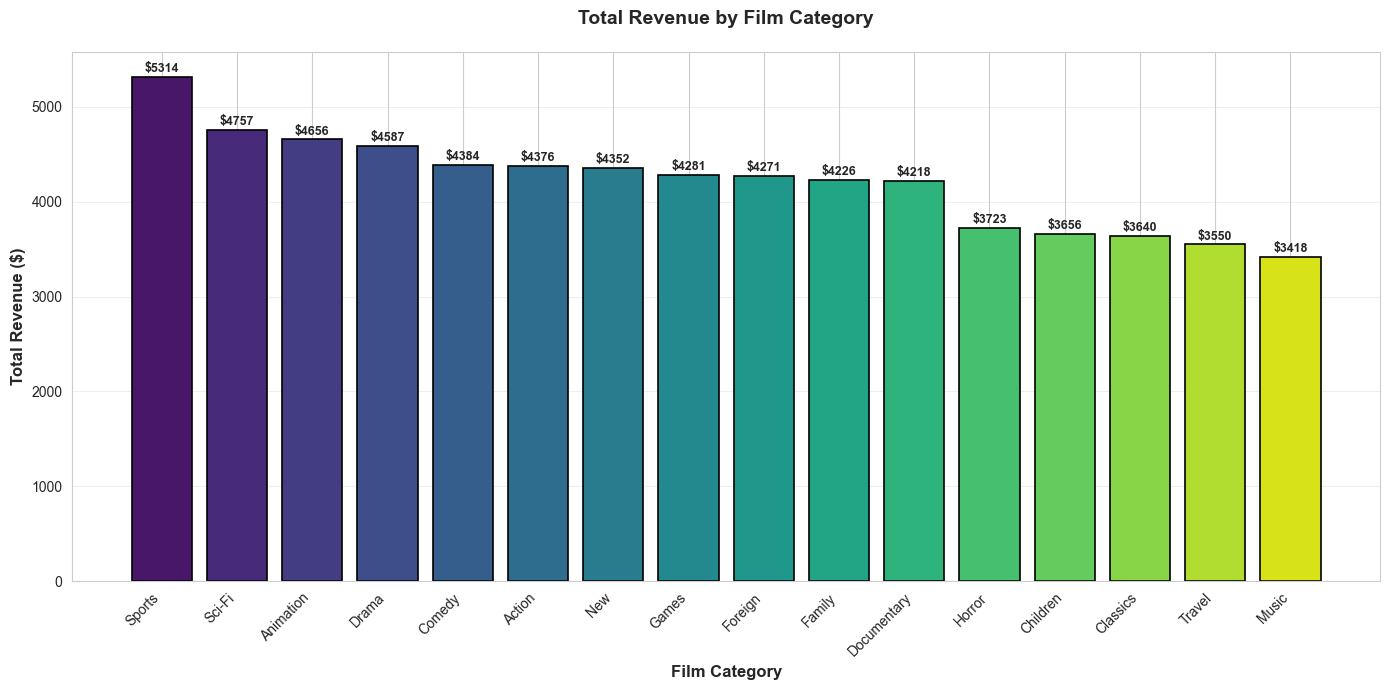


Revenue by Category:



,category,total_revenue
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


In [29]:
query_2b = """
SELECT 
    c.name AS category,
    SUM(p.amount) AS total_revenue
FROM category c
JOIN film_category fc ON c.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN payment p ON r.rental_id = p.rental_id
GROUP BY c.name
ORDER BY total_revenue DESC;
"""

revenue_by_category = conn.sql(query_2b).df()

# Create bar chart
plt.figure(figsize=(14, 7))
colors = sns.color_palette("viridis", len(revenue_by_category))
plt.bar(revenue_by_category['category'], revenue_by_category['total_revenue'], 
        color=colors, edgecolor='black', linewidth=1.2)
plt.xlabel('Film Category', fontsize=12, fontweight='bold')
plt.ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
plt.title('Total Revenue by Film Category', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (cat, value) in enumerate(zip(revenue_by_category['category'], revenue_by_category['total_revenue'])):
    plt.text(i, value + 20, f'${value:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nRevenue by Category:\n")
revenue_by_category

---

## Summary of Findings

### Key Insights for The Manager:

1. **Long Movies**: We have several movies over 3 hours long that may appeal to customers looking for extended viewing experiences.

2. **Love-Themed Movies**: Romance continues to be a popular theme with multiple titles containing "love" in the title.

3. **Movie Length Statistics**: Our film library has a good variety of lengths, with the average around 115 minutes.

4. **Premium Rentals**: The most expensive movies per day can be identified for potential premium pricing strategies.

5. **Star Actors**: Certain actors appear in significantly more films, making them valuable for marketing.

6. **Top Customers**: The top 5 customers by spend should receive special attention and loyalty rewards.

7. **Revenue Categories**: Some film categories significantly outperform others in revenue generation, suggesting where to focus inventory expansion.

### Recommendations:

- Implement a VIP program for top-spending customers
- Expand inventory in high-revenue categories
- Consider promotional campaigns featuring top actors
- Optimize rental pricing based on cost-per-day analysis

---

## Clean Up

In [30]:
# Close database connection
conn.close()
print("✓ Database connection closed")

✓ Database connection closed
